In [ ]:
import numpy as np
import numpy.linalg as la
from sklearn.preprocessing import normalize
from sklearn.decomposition import FastICA
from math import sqrt, e, tanh
from copy import deepcopy
from scipy.stats import kurtosis
from statsmodels.api import qqplot
import matplotlib.pyplot as plt
from collections import namedtuple
import mne
import pandas as pd
#from mne.preprocessing import ICA
import warnings
warnings.filterwarnings('ignore')

### Notes on PCA

- Let centered data matrix be<br>
$X_c \in \mathbb{R}^{n \times d}$, ($n$ samples of $d$ dimensional data)<br>
and covariance matrix<br>
$\Sigma = \tfrac{1}{n} (X_c)^\top X_c$

- Eigenvalue $λ_i$ of covariance matrix $\Sigma$ is the “variance” in the direction of its corresponding unit eigen vector $v_i \in \mathbb{R}^{d}$

- The projection values of each sample vector of $X_c$ onto $v_i$ (stacked in column vector form) is $X_c v_i$
> Remark: Since $X_c$ is centered data, each column of $X_c$ sums to zero, and since $X_c v_i$ is a linear combination of the columns of $X_c$, the column vector $X_c v_i$ also sums to zero. Therefore, it need not be centered again before computing the covariance matrix (which in this case is just variance since there's only one dimension).

- So the variance is  
$$
\begin{align*}
\operatorname{Var}(X_c v_i)
&= \tfrac{1}{n} (X_c v_i)^\top (X_c v_i) \\
&= v_i^\top (X_c^\top X_c) v_i \\
&= v_i^\top \Sigma v_i \\
&= \lambda_i \, v_i^\top v_i \\
&= \lambda_i \quad \text{(since $\|v_i\|=1$).}
\end{align*}
$$

- Now let $P$ be the matrix composed of the $k$ unit eigenvectors whose corresponding eigenvalues are the $k$ largest among all $n$ eigenvalues. Then the covariance of the dimension-reduced data $Z = X_c P \in \mathbb{R}^{n \times k}$ is

$$
\begin{align*}
\operatorname{Cov}(Z)
&= \tfrac{1}{n} Z^\top Z \\
&= \tfrac{1}{n} (X_c P)^\top (X_c P) \\
&= P^\top \Big( \tfrac{1}{n} X_c^\top X_c \Big) P \\
&= P^\top \Sigma P \\
&= \Lambda,
\end{align*}
$$

where $\Lambda$ is the diagonal matrix of the eigenvalues corresponding to the eigenvectors in $P$.  
Since $\Sigma$ is symmetric, its eigenvectors can be chosen orthonormally, so $P^\top P = I$.

### Implementing FastICA (data whitening included) from scratch

In [ ]:
def whiten(X, method='svd'):
    '''X.shape = (n, m)
       n: number of rows = number of independent components
       m: number of columns = number of samples'''
    X = X - np.mean(X, axis=1, keepdims=True)
    if method == 'svd':
        U, S, Vt = la.svd(X.T)  # SVD performed on X.T which is of shape (m, n) = (n_samples, n_components)
        Z = normalize(X.T @ Vt.T, axis=0)  # columns of V (i.e., rows of Vt) are the principal directions; Z.shape = (m, n)
        print('Data whitened through SVD')
        return Z.T
    elif method == 'eig':
        cov = X @ X.T
        eigvals, eigvecs = la.eig(cov)
        D_inv_sqrt = np.diag(1/np.sqrt(eigvals))
        print('Data whitened through EVD')
        return D_inv_sqrt @ eigvecs.T @ X

def f(u): # not used in the FastICA algorithm
    return -e**(-(u**2)/2)

# only suitable for data matrices of medium size
def fastica(X, C, func='exp', W0=None, max_iters=10000, epsilon=1e-4, display_progress=True):
    '''X: Whitened data matrix of shape (n, m)
       C: Number of desired components
       func: The g function (i.e., contrast function). Could be either "logcosh", "exp", or "cube".
             You can also provide your own function, which should return a tuple of functions (g, g')
       W0: Initial value of unmixing matrix'''
    n, m = X.shape
    if W0 == None:
        W0 = 1 * normalize(np.random.randn(n, C), axis=0)
        print('No initial value for W provided; randomized from standard normal distribution')
    W, ones, epsilon = deepcopy(W0), np.ones(m), epsilon*1e-8

    if func == 'logcosh':
        vg, vg_ = np.tanh, np.vectorize(lambda u: 1-(tanh(u))**2)
    elif func == 'exp':
        vg, vg_ = np.vectorize(lambda u: u*(e**(-(u**2)/2))), np.vectorize(lambda u: (1-u**2)*(e**(-(u**2)/2)))
    elif func == 'cube':
        vg, vg_ = np.vectorize(lambda u: u**3), np.vectorize(lambda u: 3*(u**2))
    else:
        try:
            g, g_ = func
            vg, vg_ = np.vectorize(g), np.vectorize(g_)
        except TypeError:
            print('Invalid input of func')
            return None

    for p in range(C):
        i = 0
        while i <= max_iters:
            temp = deepcopy(W[:,p])
            W[:,p] = (1/m) * X @ (vg(W[:,p].T @ X)).T - (1/m) * np.inner(vg_(W[:,p].T @ X), ones) * W[:,p]
            W[:,p] -= sum([(W[:,p].T @ W[:,j]) * W[:,j] for j in range(p)])
            W[:,p] = 1 * W[:,p]/la.norm(W[:,p])
            if abs(1 - abs(np.inner(W[:,p], temp))) < epsilon:
                break
            i += 1
        if display_progress:
            print('epsilon = ', 1e+8*abs(1 - abs(np.inner(W[:,p], temp))))
            print(f'Column {p+1} extracted after {i-1} iterations')
    ICA_Output = namedtuple('ICA_Ouput', ['W0', 'W', 'S'])
    ica_output = ICA_Output(W0, W, W.T @ X)
    return ica_output

In [ ]:
epochs = mne.read_epochs_eeglab('subj033_rej-for-ica.set')
data = epochs.get_data(units='uV', copy=False)
data.shape

Extracting parameters from C:\Users\jowan\cllt2024\machine-learning\subj033_rej-for-ica.set...
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Ready.


(200, 33, 1100)

### Checking non-Gaussianity of ICA components with kurtosis

After extracting the 600–900 ms post-stimulus segment, I whitened the data and ran my custom FastICA implementation to obtain 33 independent components.  

To check ICA separation, the kurtosis of each recovered source signal is computed:

- **Why kurtosis?**  
  ICA relies on the principle that independent sources are non-Gaussian.

In [ ]:
X = data[10, :, 600:900]
X = whiten(X, method='svd')
W0, W, S = fastica(X, 33, func='exp', max_iters=75000, epsilon=1e-5)
print('\n')
kurtosis_arr = np.array([kurtosis(s, fisher=True) for s in S])
np.set_printoptions(precision=2, suppress=True)
print(kurtosis_arr)

Data whitened through SVD
No initial value for W provided; randomized from standard normal distribution
epsilon =  8.103517856739018e-05
Column 1 extracted after 75000 iterations
epsilon =  6.359357485052897e-05
Column 2 extracted after 75000 iterations
epsilon =  0.0008552492047897431
Column 3 extracted after 75000 iterations
epsilon =  0.0012764345136417887
Column 4 extracted after 75000 iterations
epsilon =  0.00048696602306108616
Column 5 extracted after 75000 iterations
epsilon =  0.0003107292201320888
Column 6 extracted after 75000 iterations
epsilon =  9.992007221626409e-06
Column 7 extracted after 69664 iterations
epsilon =  0.00146335166206768
Column 8 extracted after 75000 iterations
epsilon =  0.0002505107232764203
Column 9 extracted after 75000 iterations
epsilon =  0.0001759703494030873
Column 10 extracted after 75000 iterations
epsilon =  0.0010411005391119943
Column 11 extracted after 75000 iterations
epsilon =  8.271161533457416e-05
Column 12 extracted after 75000 itera

### Q–Q plots of ICA components

To further assess the Gaussianity of each ICA component, I generated Q–Q plots of the recovered sources against a theoretical normal distribution.  

- Components that closely follow the diagonal line are approximately Gaussian.  
- Components that deviate strongly in the tails are non-Gaussian.

Since ICA relies on maximizing non-Gaussianity, these plots help visually confirm if the components carry meaningful independent structure.

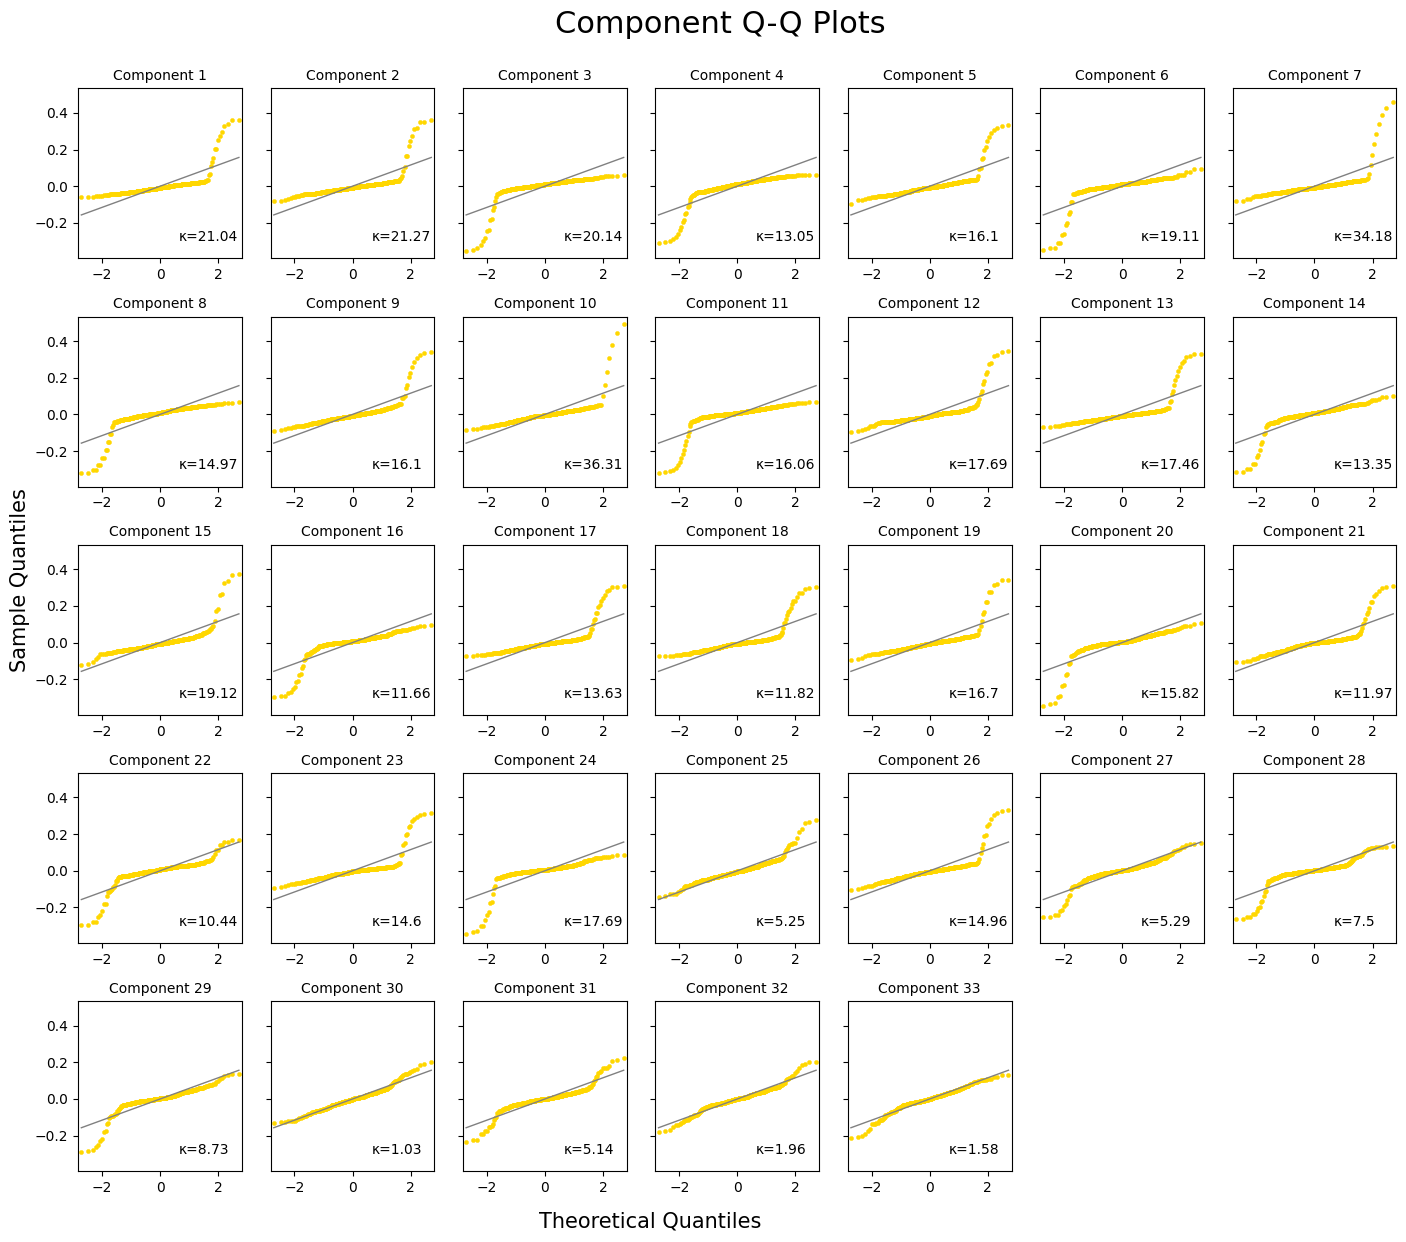

In [ ]:
def my_QQ(data, ax):
    qqplot(data, ax=ax, line='s')

    line = ax.get_lines()[0]
    line.set_markersize(3)
    line.set_marker('o')
    line.set_markerfacecolor('gold')
    line.set_markeredgewidth(0.3)
    line.set_markeredgecolor('gold')

    reference_line = ax.get_lines()[1]
    reference_line.set_color('grey')
    reference_line.set_linewidth(1)

    ax.set_xlabel('')
    ax.set_ylabel('')

components = range(1, 36)
figure, axes = plt.subplots(5, 7, figsize=(14, 12), sharey=True)
for ax, i in zip(axes.copy().flatten(), components):
    try:
        ax.set_title(f'Component {i}', fontsize='10')
        ax.text(0.65, -0.3, f'κ={round(kurtosis_arr[i-1], 2)}')
        my_QQ(S[i-1], ax=ax)
    except IndexError:
        ax.remove()
plt.suptitle('Component Q-Q Plots', fontsize=22, y=1)
figure.text(0.45, -0.01, 'Theoretical Quantiles', ha='center', va='center', fontsize='15')
figure.text(0.00001, 0.525, 'Sample Quantiles', ha='center', va='center', fontsize='15', rotation='vertical')
figure.tight_layout()
plt.show()

### FastICA of Epoch 11 (index 10 in Python) via `sklearn.decomposition.FastICA`

In [ ]:
# in sklearn's FastICA, Source = Unmix @ Whitened_Data
# Whitened_Data is of shape (n, m), where n is the number of features/components, and m the number of samples
# However, the data array passed as an argument to sklearn's FastICA should be of shape (m, n)

epoch11 = data[10]

ica_model = FastICA(n_components=None, fun='exp', algorithm='deflation', whiten='unit-variance',
                    max_iter=50000, tol=1e-10, w_init=None)
epoch11_ica = ica_model.fit_transform(epoch11.T).T
W_sklearn = ica_model.components_

kurtosis_arr_ = np.array([kurtosis(s_, fisher=True) for s_ in epoch11_ica])
display('Component kurtosis: ', kurtosis_arr_)

'Component kurtosis: '

array([14.64, 16.78, 13.82,  8.75,  9.86,  9.16,  6.82, 13.68,  9.95,
        7.23,  5.27,  6.76,  6.57, 10.1 ,  7.96,  4.97,  7.56,  5.97,
        5.35,  2.93,  5.98,  2.91,  2.19,  4.08, -0.78,  2.24, -0.95,
        1.15,  1.31,  0.91,  1.41, -0.39, -0.11])

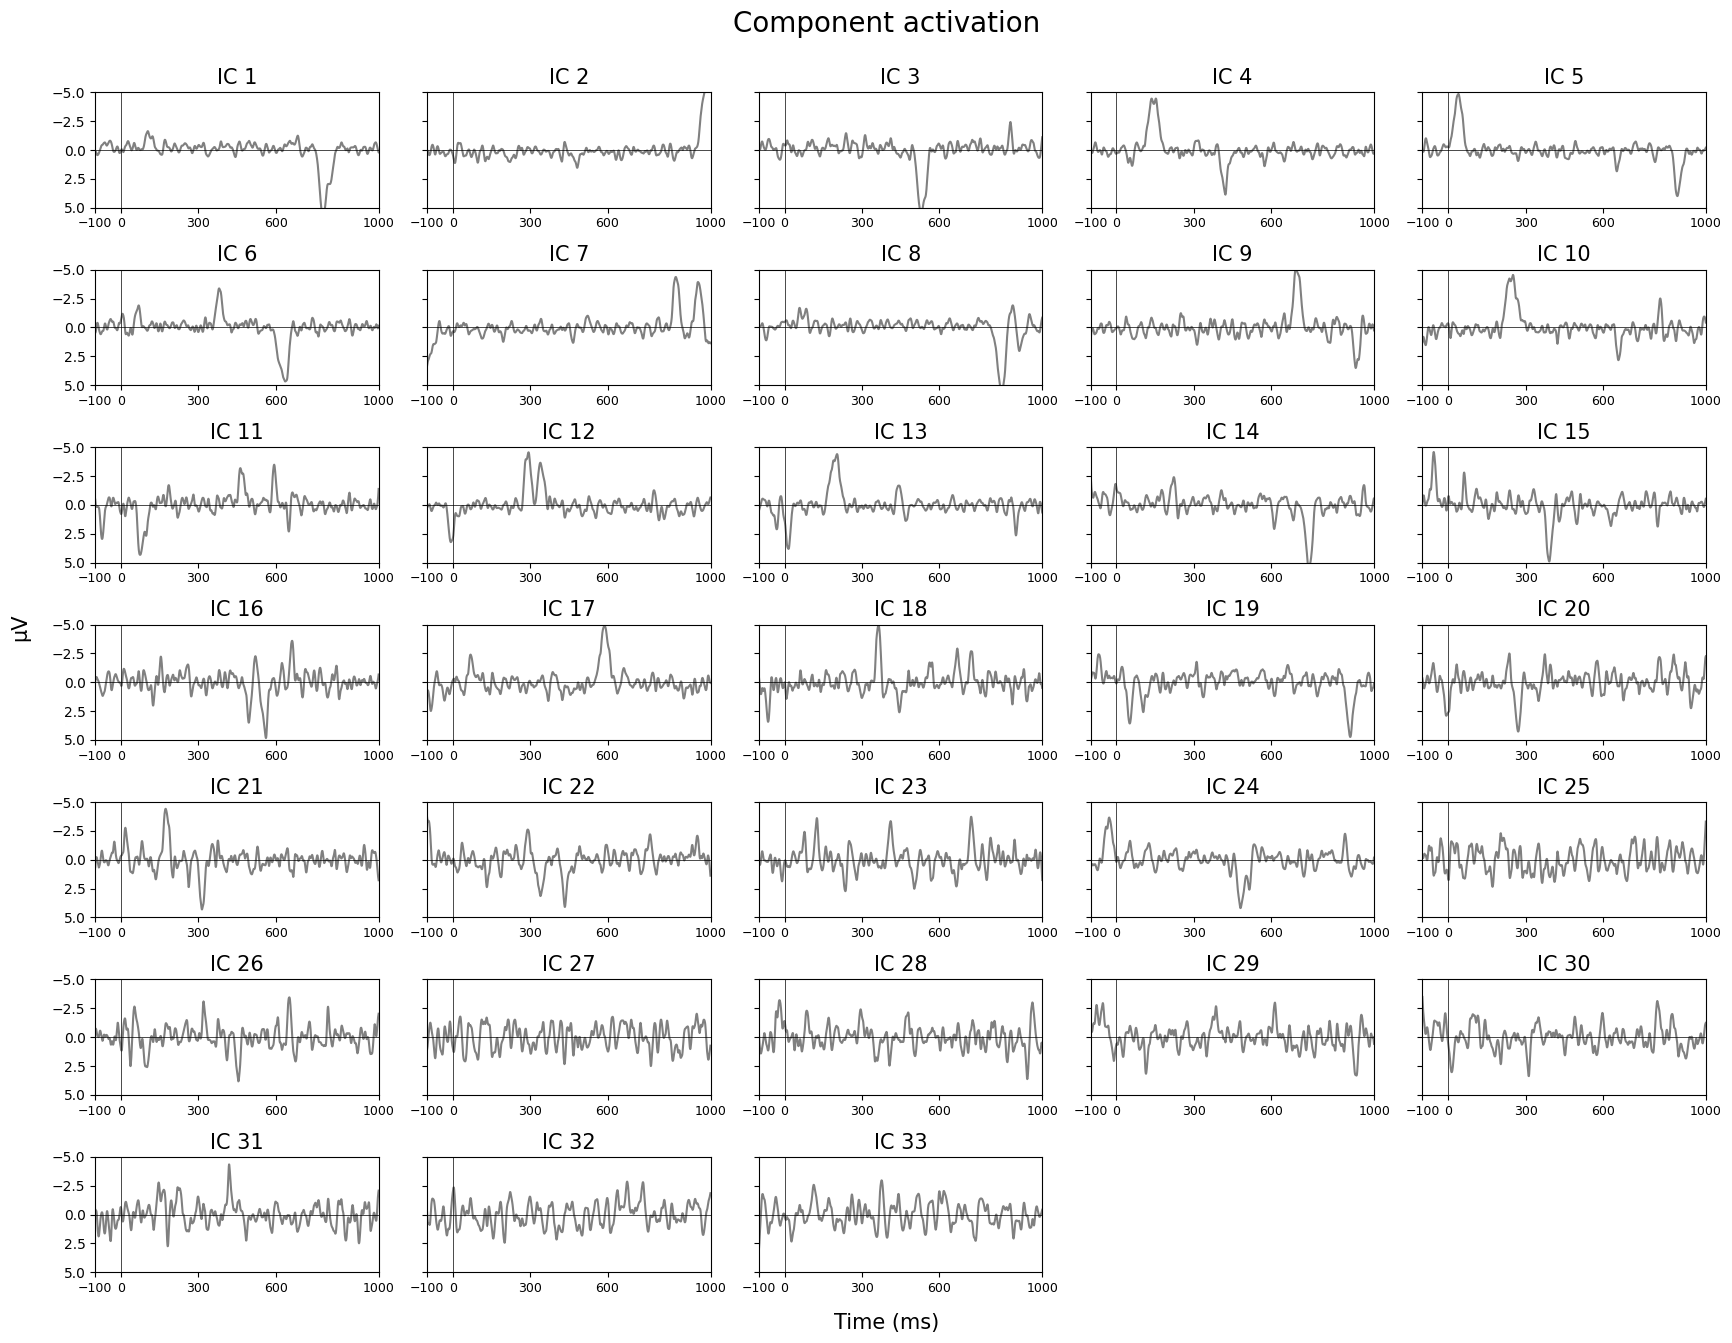

In [ ]:
t, components = [i for i in range(-100, 1000)], range(1,36)
figure, axes = plt.subplots(7,5, figsize=(17, 13), sharey=True)
for ax, i in zip(axes.copy().flatten(), components):
    try:
        ax.plot(t, epoch11_ica[i-1], color='grey')
    except IndexError:
        ax.remove()
    else:
        ax.axvline(x=0, color='black', linewidth=0.5)
        ax.axhline(y=0, color='black', linewidth=0.5)
        ax.set_title(f'IC {i}', fontsize=15)
        ax.set_xlim(-100, 1000)
        ax.set_xticks([-100, 0, 300, 600, 1000])
        ax.tick_params(axis='x', labelsize=9)
        ax.set_ylim(-5, 5)
        #ax.set_yticklabels([-5, 0, 5], fontsize=9)
        ax.invert_yaxis()
plt.suptitle('Component activation', fontsize=20, y=1)
figure.text(0.5, -0.01, 'Time (ms)', ha='center', va='center', fontsize='15')
figure.text(-0.01, 0.525, 'µV', ha='center', va='center', fontsize='15', rotation='vertical')
figure.tight_layout()
plt.show()

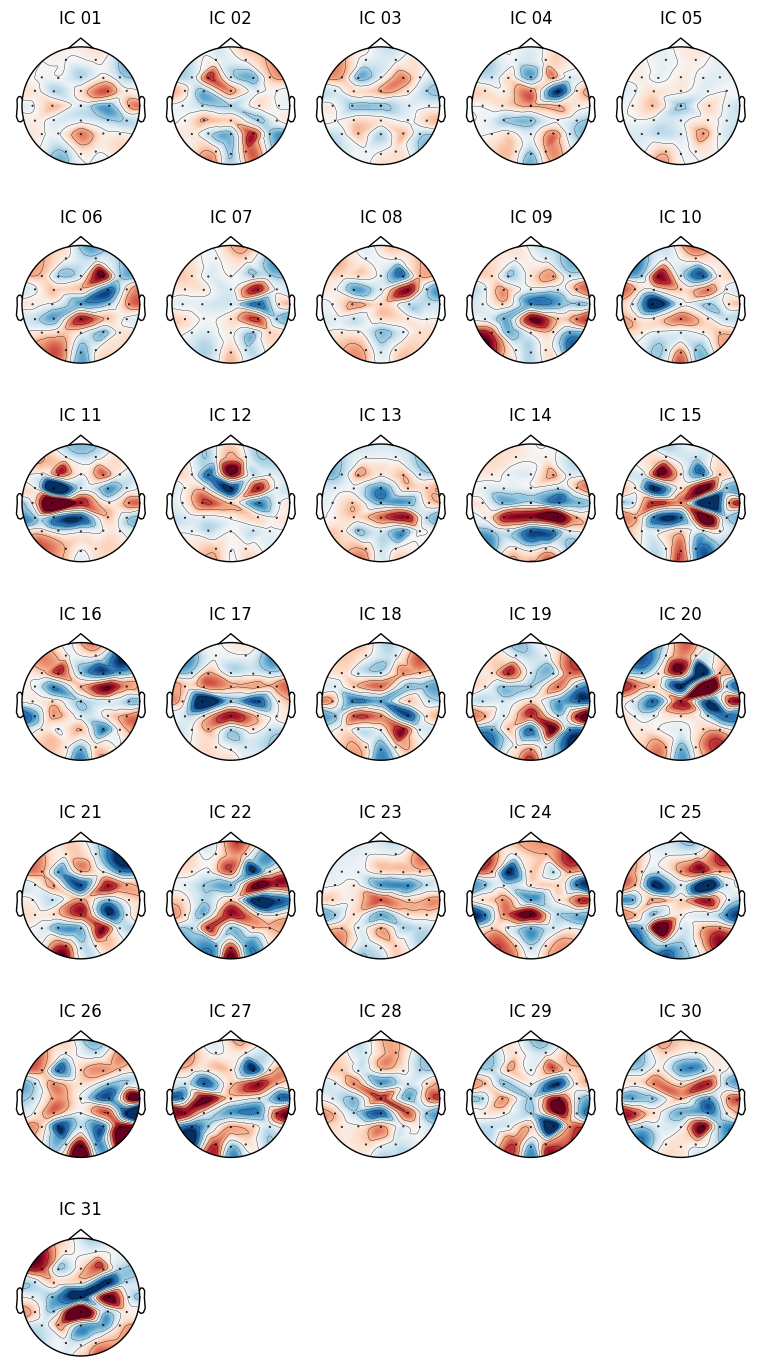

In [ ]:
W_sklearn_drop_ch = np.delete(W_sklearn, (epochs.ch_names.index('HEO'), epochs.ch_names.index('M2')), axis=0)
W_sklearn_drop_ch = np.delete(W_sklearn_drop_ch, (epochs.ch_names.index('HEO'), epochs.ch_names.index('M2')), axis=1)
ch_names = epochs.copy().drop_channels(['HEO','M2']).ch_names
ch_names = [i if 'Z' not in i else i[:-1]+'z' for i in ch_names]
ch_names[ch_names.index('FP1')], ch_names[ch_names.index('FP2')] = 'Fp1','Fp2'
info = mne.create_info(ch_names=ch_names, sfreq=1, ch_types='eeg')
info.set_montage('biosemi64', on_missing='ignore');

unmix_evoked = mne.EvokedArray(data=W_sklearn_drop_ch.T, info=info, tmin=1)
mne.viz.plot_evoked_topomap(unmix_evoked, vlim=(-7.5e+5, 7.5e+5), times=range(1,32),
                            nrows=7, colorbar=False, time_format='IC %02d');

### Cross-Check with EEGLAB
- This has been fun! Ran `runica.m` again in EEGLAB and imported `EEG.icaweights` into Python by which I multiplied the epochs array to reconstruct the source signals. The weight matrix topo maps are similar (discrepancies likely due to differences in interpolation methods). However, EEGLAB's plot function must've applied a scaling factor or something as those blinks at IC1 look many times larger in Python...

![](https://drive.google.com/uc?export=view&id=12rcNmaXrcrrJwxmNjCsz19_BcrNnqjzf)

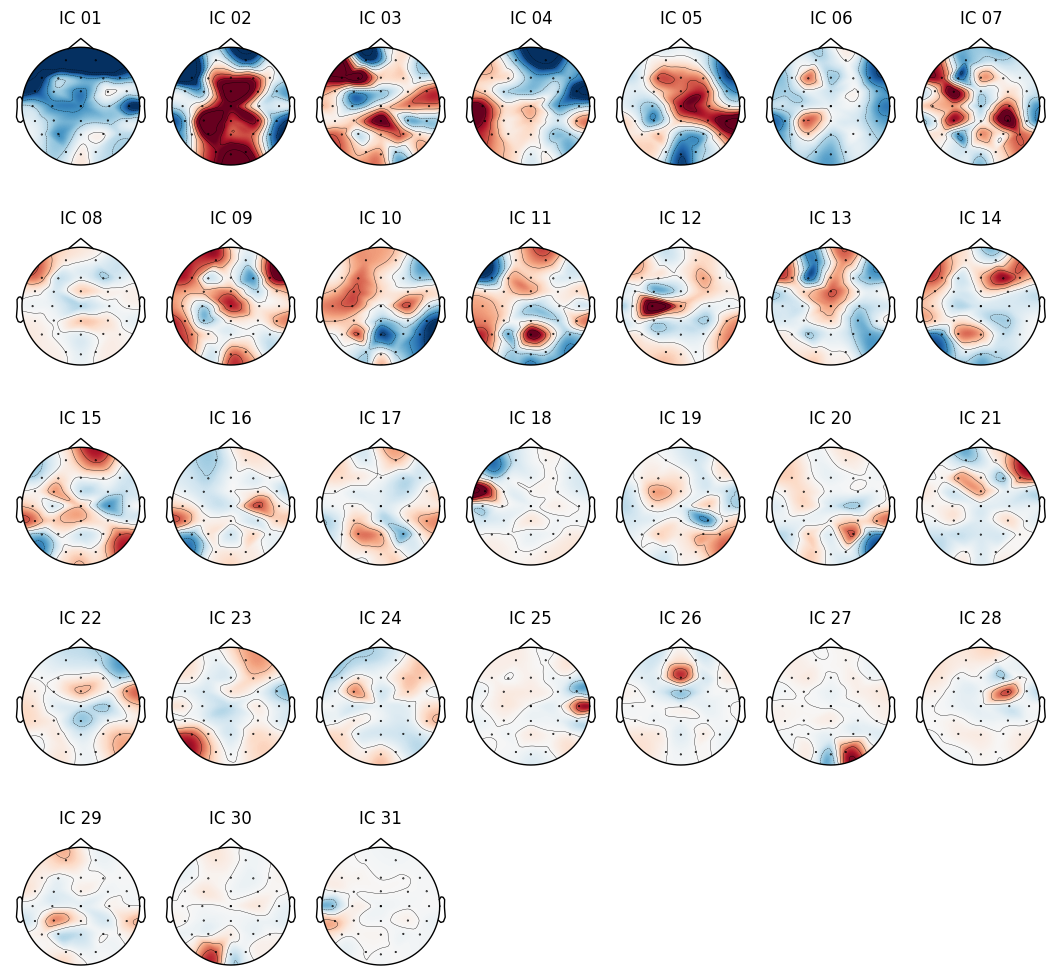

In [ ]:
icaweights = pd.read_csv('C:\\Users\\jowan\\erpclass\\ICA-tutorial\\icaweights.csv')
to_insert = np.array(icaweights.columns, dtype=float).reshape(1,33)
icaweights = np.append(to_insert, icaweights.to_numpy(), axis=0)

icaweights_drop_ch = np.delete(icaweights, (epochs.ch_names.index('HEO'), epochs.ch_names.index('M2')), axis=0)
icaweights_drop_ch = np.delete(icaweights_drop_ch, (epochs.ch_names.index('HEO'), epochs.ch_names.index('M2')), axis=1)

icaweights_evoked = mne.EvokedArray(data=icaweights_drop_ch.T, info=info, tmin=1)
mne.viz.plot_evoked_topomap(icaweights_evoked, vlim=(-5e+5, 5e+5), times=range(1,32),
                            nrows=5, colorbar=False, time_format='IC %02d');

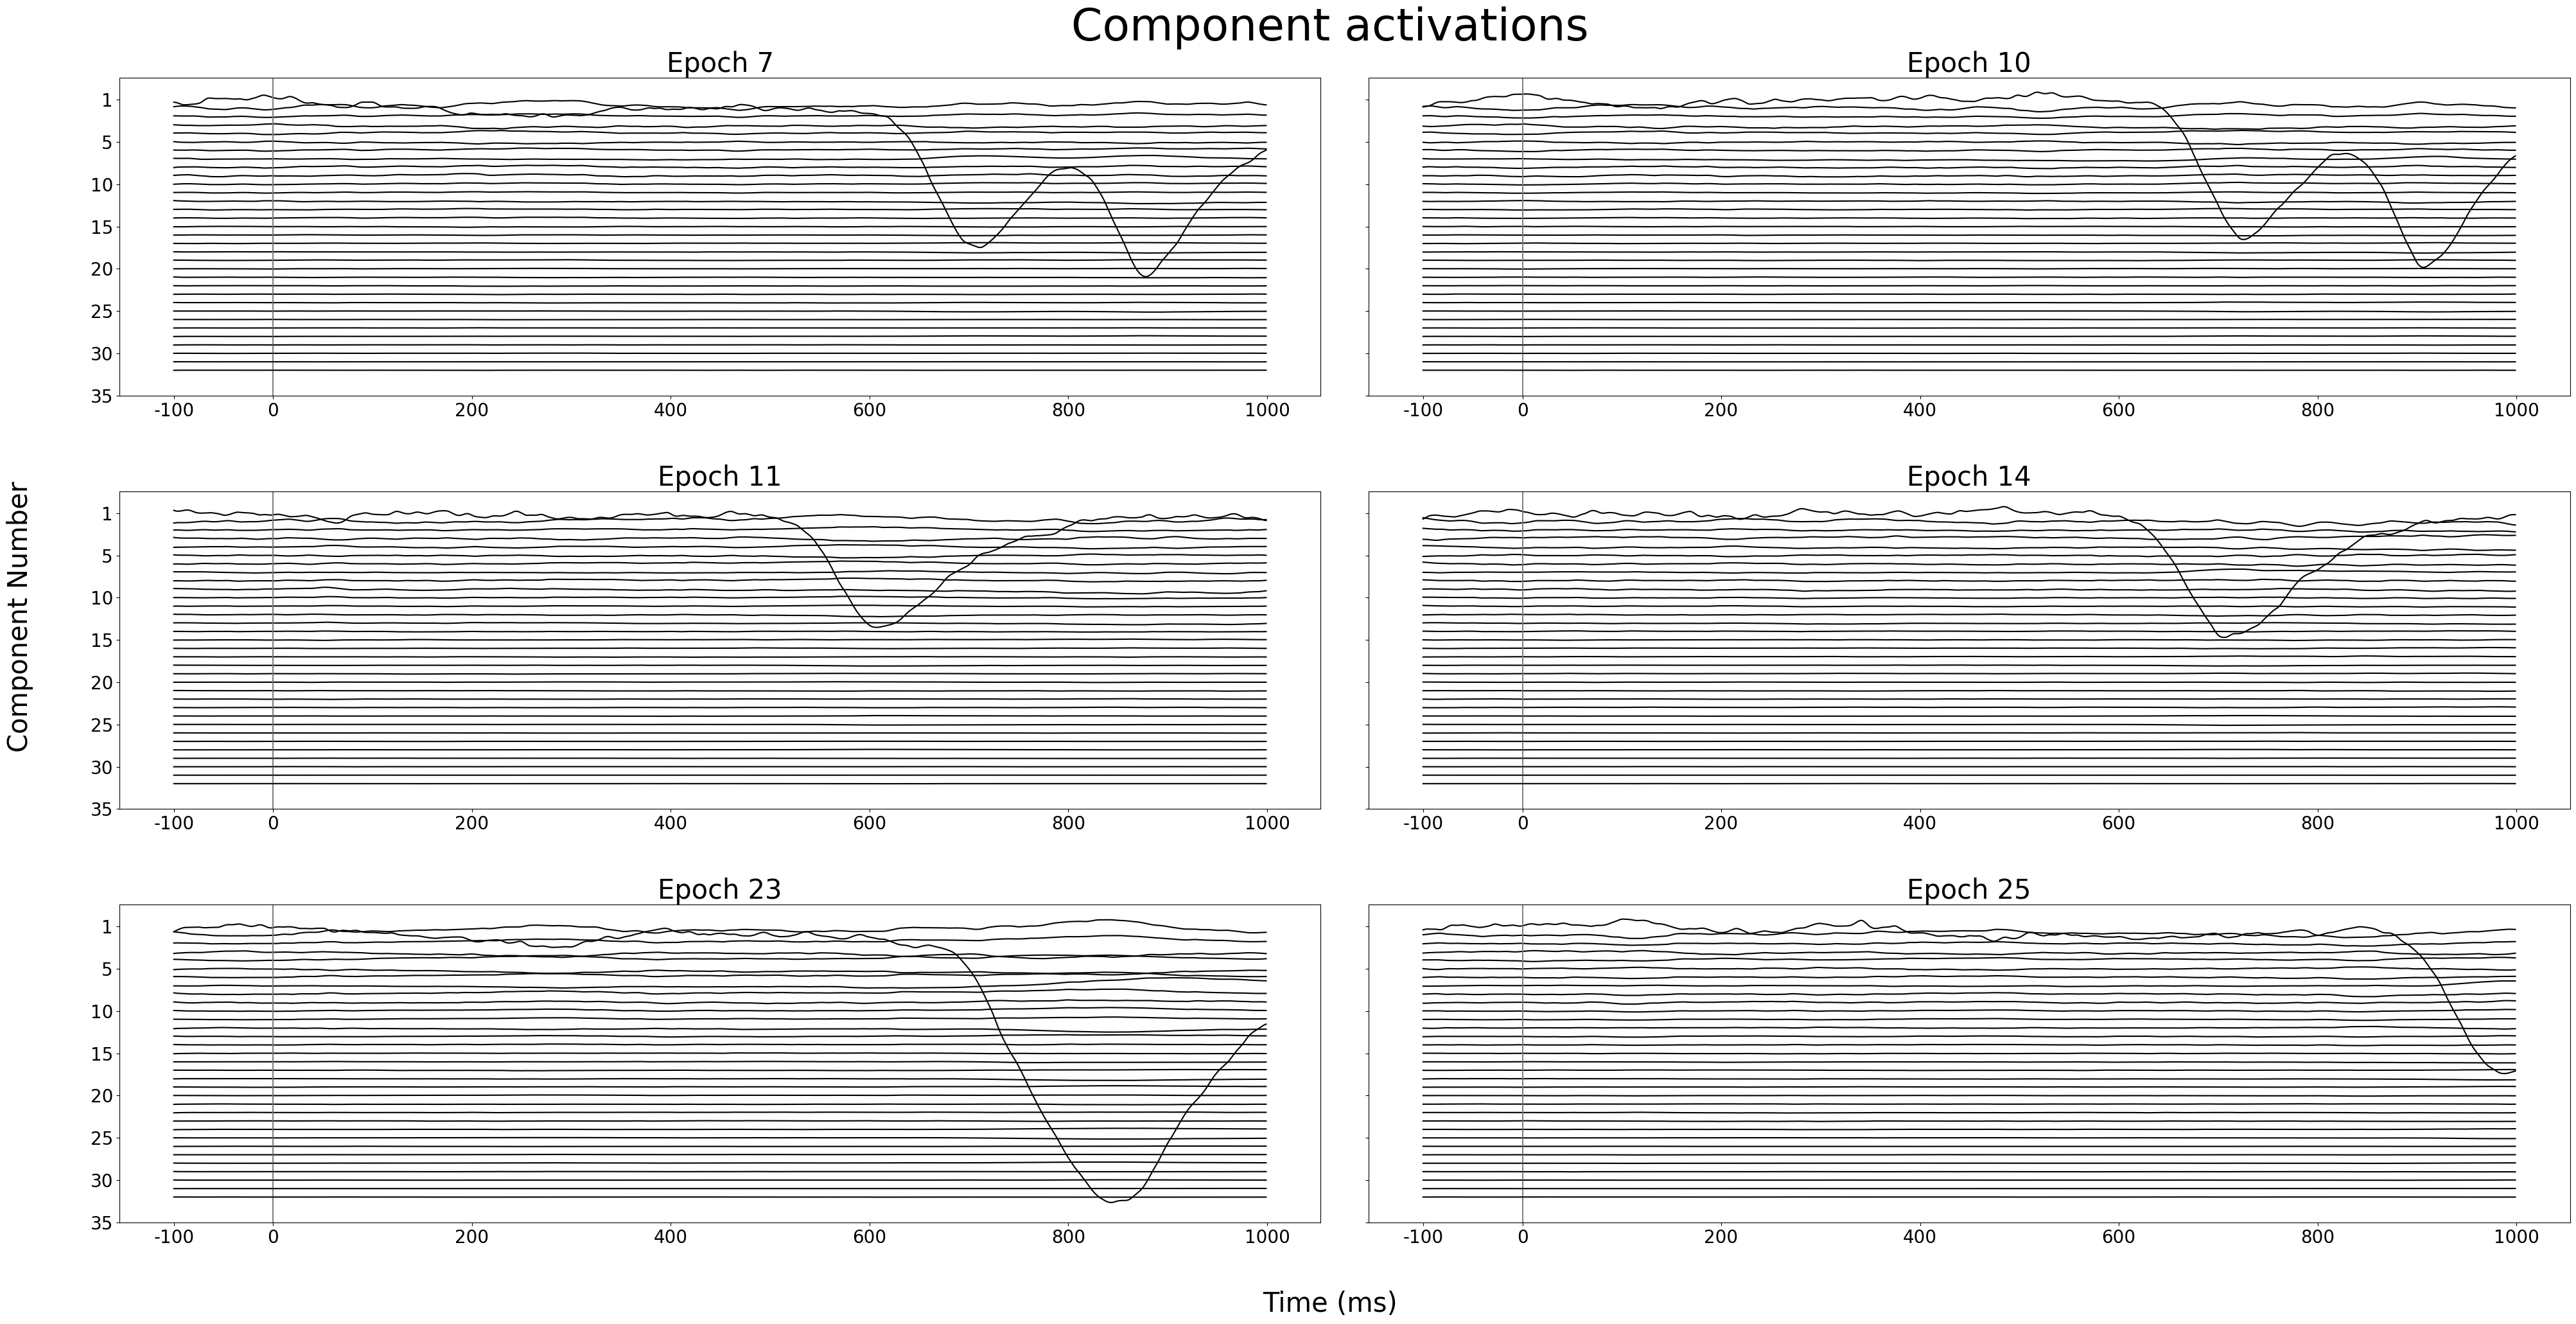

In [ ]:
icaweights_ = icaweights.reshape(1,33,33)
source = np.einsum('...ij,...jk', icaweights_, data)
offsets = np.array([i*(-150) for i in range(33)]).reshape(33,1)
epochs = [7,10,11,14,23,25]

figure, axes = plt.subplots(3,2, figsize=(40, 20), sharey=True)
for epoch, ax in zip(epochs, axes.copy().flatten()):
    source_ = source[epoch-1] + offsets
    for i in range(33):
        ax.plot(t, source_[i], color='black')
        ax.axvline(x=0, color='grey', linewidth=0.2)
        ax.set_xticks([-100,0,200,400,600,800,1000])
        ax.set_xticklabels([-100,0,200,400,600,800,1000], fontsize=20)
        ax.set_yticks([0]+[i*5*(-150) for i in range(1,8)])
        ax.set_yticklabels([1]+[i*5 for i in range(1,8)], fontsize=20)
        ax.set_title(f'Epoch {epoch}', fontsize=30)
figure.tight_layout(pad=5)
figure.text(0.5, -0.01, 'Time (ms)', ha='center', va='center', fontsize=30)
figure.text(-0.01, 0.525, 'Component Number', ha='center', va='center', fontsize=30, rotation='vertical')
plt.suptitle('Component activations', fontsize=50, y=1)
plt.show()

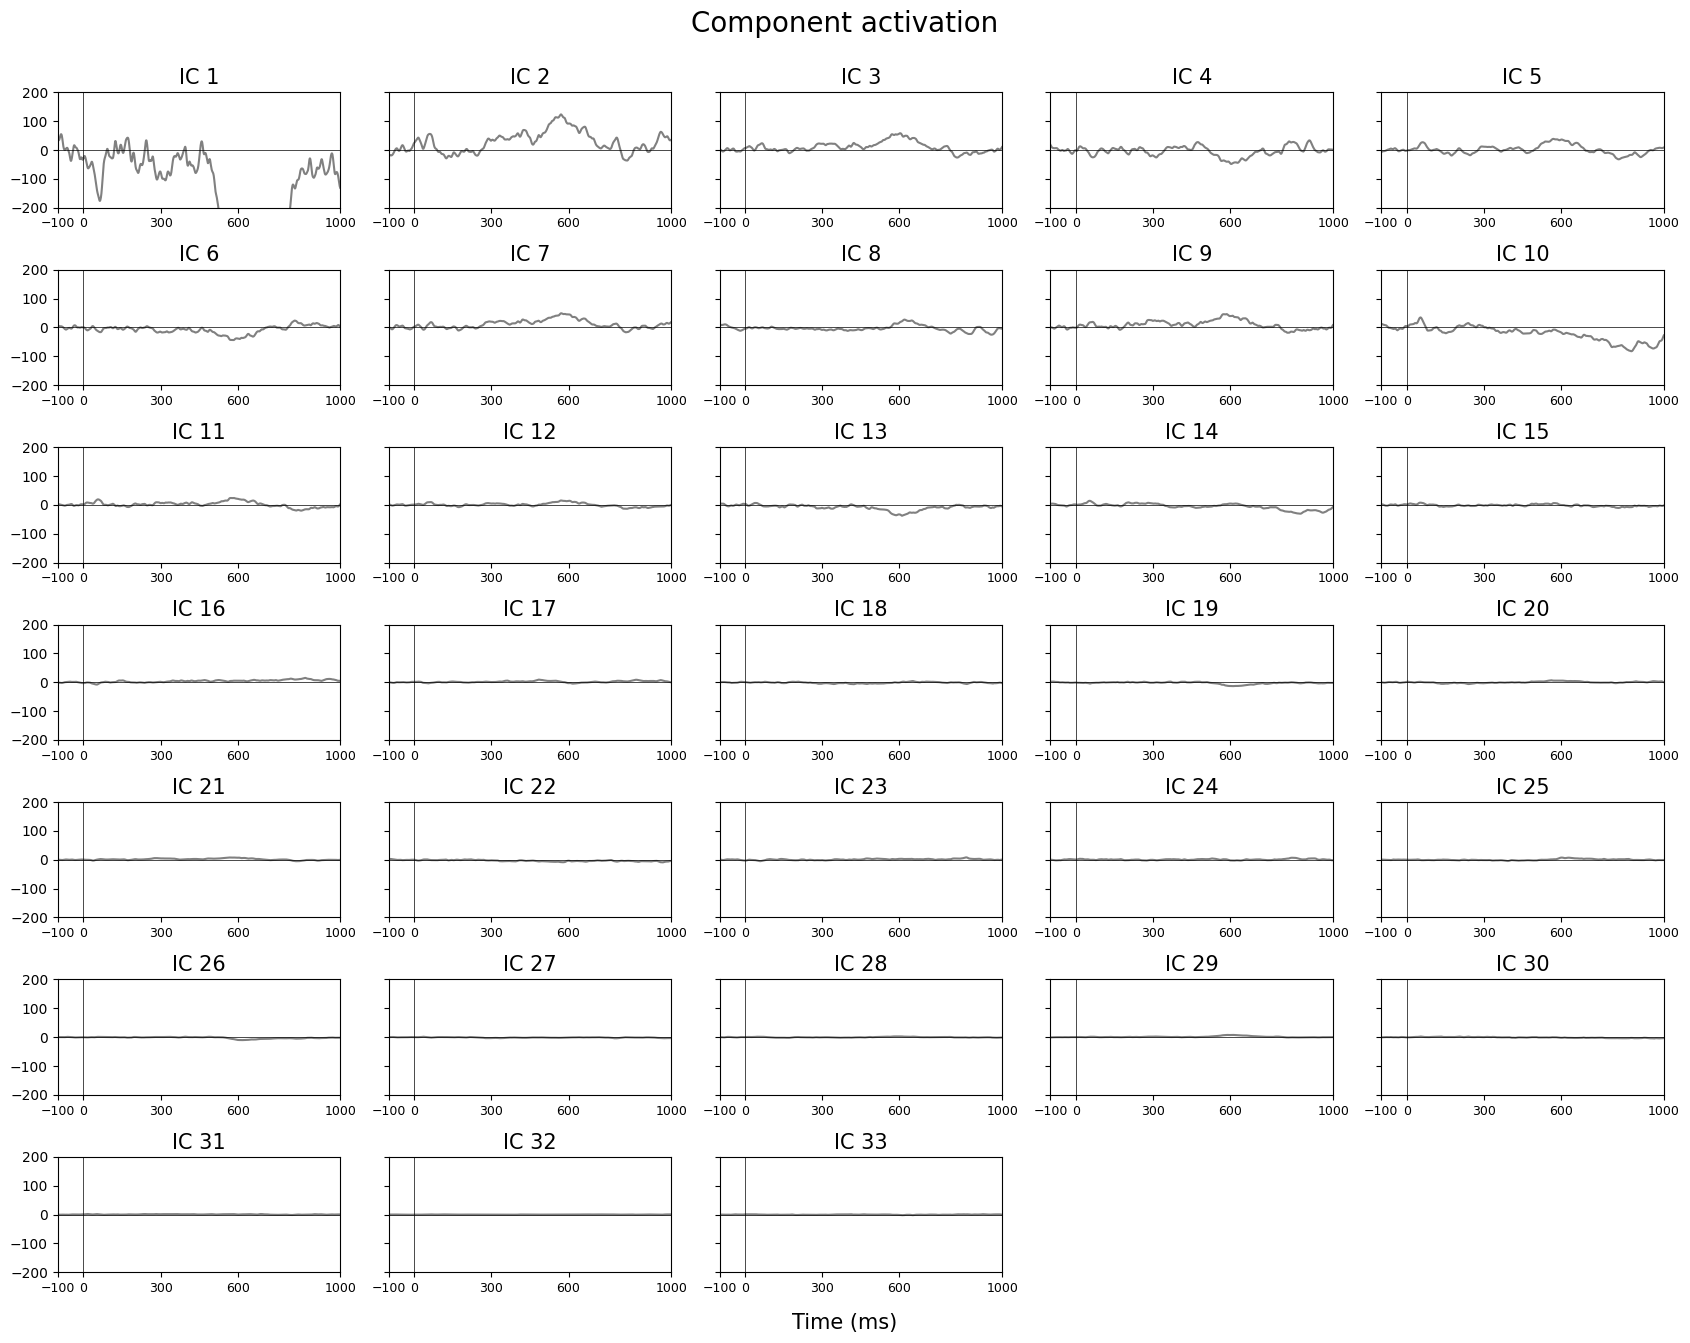

In [ ]:
icaweights_ = icaweights.reshape(1,33,33)
source = np.einsum('...ij,...jk', icaweights_, data)

figure, axes = plt.subplots(7,5, figsize=(17, 13), sharey=True)
for ax, i in zip(axes.copy().flatten(), components):
    try:
        ax.plot(t, source[10][i-1], color='grey')
    except IndexError:
        ax.remove()
    else:
        ax.axvline(x=0, color='black', linewidth=0.5)
        ax.axhline(y=0, color='black', linewidth=0.5)
        ax.set_title(f'IC {i}', fontsize=15)
        ax.set_xlim(-100, 1000)
        ax.set_xticks([-100, 0, 300, 600, 1000])
        ax.tick_params(axis='x', labelsize=9)
        ax.set_ylim(-200, 200)
        #ax.set_yticklabels([-5, 0, 5], fontsize=9)
        #ax.invert_yaxis()
plt.suptitle('Component activation', fontsize=20, y=1)
figure.text(0.5, -0.01, 'Time (ms)', ha='center', va='center', fontsize='15')
#figure.text(-0.01, 0.525, 'µV', ha='center', va='center', fontsize='15', rotation='vertical')
figure.tight_layout()
plt.show()

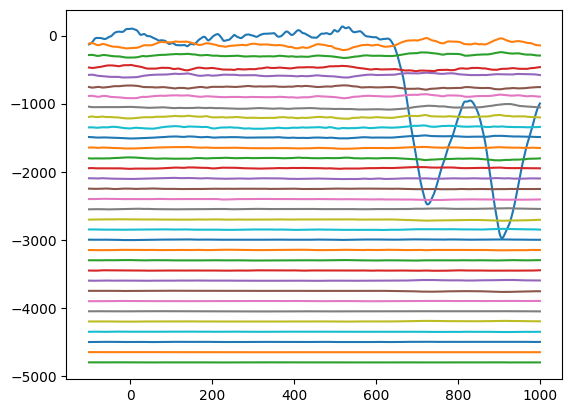

In [ ]:
offsets = np.array([i*(-150) for i in range(33)]).reshape(33,1)
source_11 = source[9] + offsets
for i in range(33):
    plt.plot(t, source_11[i])
